In [16]:
import math
import numpy as np
import torch
import gpytorch
import pandas as pd
from pyDOE2 import lhs
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood
from scipy.stats import qmc

###################
# Define GP Model #
###################

class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims = 3))


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

def validate_inputs(bounds):
    for lower, upper in bounds:
        if lower >= upper:
            raise ValueError("Lower bound must be less than upper bound.")

def scale_inputs(x, voltage_bounds, time_bounds, concentration_bounds,
                 voltage_target, time_target, concentration_target):

    validate_inputs([voltage_bounds, time_bounds, concentration_bounds])
    voltage, time, concentration = x[:, 0], x[:, 1], x[:, 2]
    
    voltage_scaled = voltage_target[0] + ((voltage - voltage_bounds[0]) * 
                                          (voltage_target[1] - voltage_target[0]) / 
                                          (voltage_bounds[1] - voltage_bounds[0]))
    
    # Using numpy for vectorized log scaling
    time_scaled = time_target[0] + ((np.log(time) - np.log(time_bounds[0])) * 
                                    (time_target[1] - time_target[0]) / 
                                    (np.log(time_bounds[1]) - np.log(time_bounds[0])))
    
    concentration_scaled = concentration_target[0] + ((np.log(concentration) - np.log(concentration_bounds[0])) * 
                                                      (concentration_target[1] - concentration_target[0]) / 
                                                      (np.log(concentration_bounds[1]) - np.log(concentration_bounds[0])))
    
    x_scaled = np.stack((voltage_scaled, time_scaled, concentration_scaled), axis=1)
    return x_scaled
import pandas as pd
import numpy as np
import torch

def load_and_preprocess_data(filepath):
    try:
        data_df = pd.read_csv(filepath)
    except FileNotFoundError:
        print("The specified file was not found.")
        return None, None

    voltage = data_df['voltage'].values
    time = data_df['time'].values
    concentration = data_df['concentration'].values
    response = data_df['deltaE'].values
    bleachCP = data_df['bleachCP'].values
    original_data = np.stack((voltage, time, concentration), axis=1)
    return original_data, response

def preprocess_inputs(original_data, response, voltage_bounds, time_bounds, concentration_bounds, voltage_target, time_target, concentration_target):
    # Scale the input features
    x_scaled = scale_inputs(original_data, voltage_bounds, time_bounds, concentration_bounds,
                            voltage_target, time_target, concentration_target)
    
    # Convert scaled data and responses to PyTorch tensors
    train_x = torch.tensor(x_scaled, dtype=torch.float32)
    train_y = torch.tensor(response, dtype=torch.float32)

    return train_x, train_y

import gpytorch

def setup_model(train_x, train_y):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    
    # Initialize model parameters (hypothetical values)
    hypers = {
        'likelihood.noise_covar.noise': torch.tensor(4.),
        'covar_module.base_kernel.lengthscale': torch.tensor([0.5, 0.5, 0.5]),
        'covar_module.outputscale': torch.tensor(20.),
    }
    model.initialize(**hypers)
    return model, likelihood


def initialize_model_parameters(model, config):
    for param, value in config.items():
        model.initialize(**{param: torch.tensor(value)})

import logging

def setup_logging():
    logging.basicConfig(filename='training_log.log', level=logging.INFO,
                        format='%(asctime)s:%(levelname)s:%(message)s')

def train_model(model, likelihood, optimizer, train_x, train_y, training_iter=500, early_stopping_rounds=None):
    model.train()
    likelihood.train()
    mll = ExactMarginalLogLikelihood(likelihood, model)  # Define mll inside the function
    
    best_loss = float('inf')
    stop_rounds = 0
    
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 10 == 0:
            logging.info(f'Iter {i + 1}/{training_iter} - Loss: {loss.item()}')
            print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item()}')
        
        # Implementing early stopping
        if early_stopping_rounds is not None and loss.item() > best_loss:
            stop_rounds += 1
            if stop_rounds >= early_stopping_rounds:
                logging.info("Early stopping triggered")
                print("Early stopping triggered")
                break
        else:
            best_loss = loss.item()
            stop_rounds = 0
# main.py
import torch.optim as optim
from gpytorch.mlls import ExactMarginalLogLikelihood
def make_predictions(model, likelihood, train_x, train_y):
    # Switch to evaluation mode
    model.eval()
    likelihood.eval()

    # Predict on the training data (or test data, if available)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # The observed_pred includes the mean and covariance of the predictions
        observed_pred = likelihood(model(train_x))
        # Get the mean of the predictive distribution
        predictions = observed_pred.mean
    
    # Convert predictions and actual values to a numpy array for plotting
    predictions_np = predictions.numpy()
    actuals_np = train_y.numpy()

    # Plotting
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    plt.plot(actuals_np, predictions_np, 'o', label='Predictions vs. Actuals')
    plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Responses')
    plt.ylabel('Predicted Responses')
    plt.title('Parity Plot for GP Model Predictions')
    plt.legend()
    plt.show()


setup_logging()
filepath = 'D:\\1-PhD\\2-PANDA-BEAR\\DataAnalysis\\PEDOT\\ML\\MLTrainingData.csv'
original_data, response = load_and_preprocess_data(filepath)


# Define bounds and targets for scaling
voltage_bounds = (0.8, 1.2)
time_bounds = (1, 100)
concentration_bounds = (0.01, 0.1)
voltage_target = (0, 1)
time_target = (0, 1)
concentration_target = (0, 1)

# Prepare inputs and outputs
train_x, train_y = preprocess_inputs(original_data, response, voltage_bounds, time_bounds, concentration_bounds,
                                     voltage_target, time_target, concentration_target)

# Set up model and likelihood
model, likelihood = setup_model(train_x, train_y)

# Optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Training the model
train_model(model, likelihood, optimizer, train_x, train_y, training_iter=500, early_stopping_rounds=50)


# Print the actual noise parameter
print('Noise std dev:', likelihood.noise.sqrt().item())

# Print the actual values of the mean, outputscale, and lengthscale parameters
for name, module in model.named_modules():
    if hasattr(module, 'raw_noise'):
        print(f'name: {name} noise: {module.noise.item()}')
    if hasattr(module, 'raw_constant'):
        print(f'name: {name} constant: {module.constant.item()}')
    if hasattr(module, 'raw_outputscale'):
        print(f'name: {name} outputscale: {module.outputscale.item()} squared units')
    if hasattr(module, 'base_kernel') and hasattr(module.base_kernel, 'raw_lengthscale'):
        print(f'name: {name} lengthscale: {module.base_kernel.lengthscale.detach().numpy()}')




Iter 10/500 - Loss: 2.701280355453491
Iter 20/500 - Loss: 2.66432785987854
Iter 30/500 - Loss: 2.6391923427581787
Iter 40/500 - Loss: 2.6220223903656006
Iter 50/500 - Loss: 2.6099910736083984
Iter 60/500 - Loss: 2.6000735759735107
Iter 70/500 - Loss: 2.583454132080078
Iter 80/500 - Loss: 2.5559959411621094
Iter 90/500 - Loss: 2.5506246089935303
Iter 100/500 - Loss: 2.549882650375366
Iter 110/500 - Loss: 2.547856330871582
Iter 120/500 - Loss: 2.5465660095214844
Iter 130/500 - Loss: 2.5458362102508545
Iter 140/500 - Loss: 2.545119524002075
Iter 150/500 - Loss: 2.544546365737915
Iter 160/500 - Loss: 2.5440638065338135
Iter 170/500 - Loss: 2.5436480045318604
Iter 180/500 - Loss: 2.5432960987091064
Iter 190/500 - Loss: 2.5429933071136475
Iter 200/500 - Loss: 2.5427331924438477
Iter 210/500 - Loss: 2.542584180831909
Iter 220/500 - Loss: 2.5423390865325928
Iter 230/500 - Loss: 2.5421504974365234
Iter 240/500 - Loss: 2.542008638381958
Iter 250/500 - Loss: 2.5418851375579834
Iter 260/500 - Loss

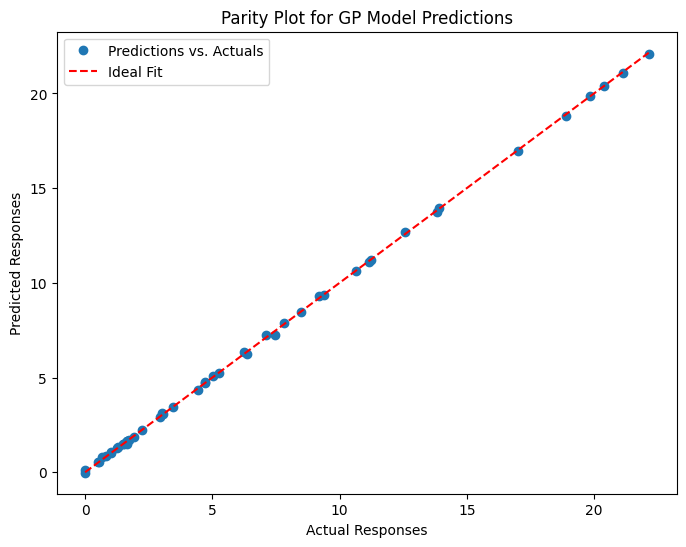

In [17]:
import warnings

# Ignore GPInputWarnings
warnings.filterwarnings("ignore", category=gpytorch.utils.warnings.GPInputWarning)

# Switch to evaluation mode
model.eval()
likelihood.eval()

# Predict on the training data (or test data, if available)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # The observed_pred includes the mean and covariance of the predictions
    observed_pred = likelihood(model(train_x))
    # Get the mean of the predictive distribution
    predictions = observed_pred.mean

# Convert predictions and actual values to a numpy array for plotting
predictions_np = predictions.numpy()
actuals_np = train_y.numpy()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(actuals_np, predictions_np, 'o', label='Predictions vs. Actuals')
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Responses')
plt.ylabel('Predicted Responses')
plt.title('Parity Plot for GP Model Predictions')
plt.legend()
plt.show()


In [18]:
# Set into eval mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [19]:
# Generate evaluation points
def generate_and_scale_lhs_points(num_points, voltage_target=(0, 1), time_target=(0, 1), concentration_target=(0, 1), concentrations=[]):
    """
    Generates and scales the LHS prediction points.
    
    Args:
    - concentration: 
        
    Returns:
    - combined_samples: A numpy array of the LHS prediction points, scaled to specified bounds.
    """
    combined_samples = []
    for concentration in concentrations:
        sampler = qmc.LatinHypercube(d=2) 
        samples = sampler.random(n=num_points)
        
        # Directly scale samples for voltage and time according to the new target bounds
        # Scale voltage to (0, 1)
        samples[:, 0] = voltage_target[0] + (samples[:, 0] * (voltage_target[1] - voltage_target[0]))
        
       # Scale time to (0, 1)
        samples[:, 1] = time_target[0] + (samples[:, 1] * (time_target[1] - time_target[0]))

        
        # This assumes concentrations are already within some understood bounds or are being directly mapped
        scaled_concentration = np.full((num_points, 1), concentration_target[0] + (concentration - 0.01) * (concentration_target[1] - concentration_target[0]) / (0.1 - 0.01))
        
        # Append scaled concentration to samples
        samples_with_concentration = np.hstack((samples, scaled_concentration))
        combined_samples.append(samples_with_concentration)
        
    # Combine samples from all concentrations into a single array
    combined_samples = np.vstack(combined_samples)
    return combined_samples

# Configuration for generating and scaling LHS points
voltage_target = (0, 1)
time_target = (0, 1)
concentration_target = (0, 1)
concentrations = [0.027, 0.023, 0.020, 0.017, 0.013, 0.010, 0.085, 0.070, 0.055, 0.040, 0.025, 0.030, 0.100, 0.088, 0.077, 0.065, 0.053, 0.042]
num_points_per_concentration = 500

# Generate and scale LHS points
test_points_scaled = generate_and_scale_lhs_points(num_points_per_concentration, voltage_target, time_target, concentration_target, concentrations)

# Convert to PyTorch tensor for use in model
test_x_scaled = torch.tensor(test_points_scaled, dtype=torch.float32)

# Assuming 'train_y' contains your observed target values and you're looking for the maximum.
current_best_response = train_y.max().item()


In [20]:
def expected_improvement(model, test_points_scaled, current_best, likelihood):
    """
    Calculates the Expected Improvement at the test points.
    
    Args:
    - model: The trained GP model.
    - test_points: Test points to evaluate (torch.Tensor).
    - current_best: The current best observed response.
    - likelihood: The likelihood used in the GP model.
    
    Returns:
    - EI: A numpy array of expected improvements for each test point.
    """
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_points_scaled))
        mean = observed_pred.mean
        std_dev = observed_pred.stddev
        z = (mean - current_best) / std_dev
        ei = (mean - current_best) * torch.distributions.Normal(0, 1).cdf(z) + std_dev * torch.distributions.Normal(0, 1).log_prob(z).exp()
        return ei.numpy()


ei = expected_improvement(model, test_x_scaled, current_best_response, likelihood)
best_point_index = np.argmax(ei)
best_test_point = test_points_scaled[best_point_index]

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    best_test_point_tensor = torch.tensor(best_test_point, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    predicted_distribution = likelihood(model(best_test_point_tensor))
    predicted_mean = predicted_distribution.mean.item()
    predicted_stddev = predicted_distribution.stddev.item()

def convert_back_to_original(best_test_point_scaled, voltage_original=(0.8, 1.2), time_original=(1, 100), 
                             concentration_original=(0.01, 0.1), voltage_target=(0, 1), time_target=(0, 1), 
                             concentration_target=(0, 1)):
    # Invert voltage scaling
    voltage = voltage_original[0] + ((best_test_point_scaled[0] - voltage_target[0]) * 
                                     (voltage_original[1] - voltage_original[0]) / 
                                     (voltage_target[1] - voltage_target[0]))
    
    # Invert scaling for time
    time_scaled_back = time_target[0] + ((best_test_point_scaled[1] - time_target[0]) * 
                                         (time_target[1] - time_target[0]) / 
                                         (time_target[1] - time_target[0]))
    time = math.log(time_original[0]) + (time_scaled_back * (math.log(time_original[1]) - math.log(time_original[0])))
    time = math.exp(time)
    
    # Invert scaling for concentration
    concentration_scaled_back = concentration_target[0] + ((best_test_point_scaled[2] - concentration_target[0]) * 
                                                           (concentration_target[1] - concentration_target[0]) / 
                                                           (concentration_target[1] - concentration_target[0]))
    concentration = math.log(concentration_original[0]) + (concentration_scaled_back * (math.log(concentration_original[1]) - math.log(concentration_original[0])))
    concentration = math.exp(concentration)
    
    return np.array([voltage, time, concentration])

best_test_point_original = convert_back_to_original(best_test_point)

print("Best Test Point in Original Values:", best_test_point_original)
print("Predicted Response at Best Test Point:", predicted_mean)
print("Standard Deviation of Prediction:", predicted_stddev)

Best Test Point in Original Values: [ 1.01865931 17.7548724   0.06812921]
Predicted Response at Best Test Point: 18.759939193725586
Standard Deviation of Prediction: 1.8650789260864258


C:\Users\harle\AppData\Local\Temp\ipykernel_20816\1594452548.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


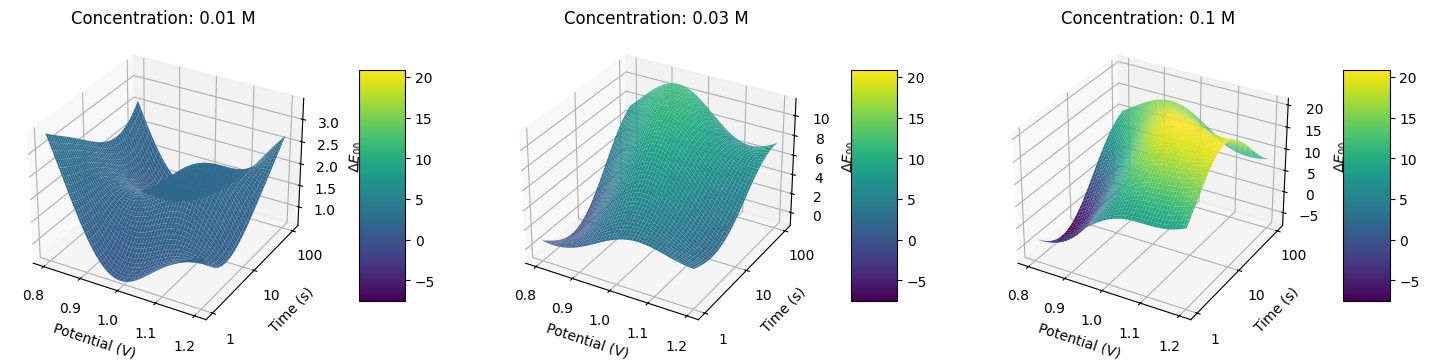

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define your concentration levels and ranges for voltage and original time
concentration_levels = [0.01, 0.03, 0.1]
voltage_range = np.linspace(0.8, 1.2, 100)
log_time_range = np.linspace(np.log(1), np.log(100), 100)
V, LogT = np.meshgrid(voltage_range, log_time_range)
T = np.exp(LogT)  # Convert back to original time for model input
voltage_bounds, time_bounds, concentration_bounds = (0.8, 1.2), (1, 100), (0.01,0.1)
voltage_target, time_target, concentration_target = (0,1), (0,1), (0,1)
# Store all predictions here to find global min and max
all_predictions = []

for concentration in concentration_levels:
    inputs_grid = np.stack((V.ravel(), T.ravel(), np.full(V.size, concentration)), axis=-1)
    inputs_scaled = scale_inputs(inputs_grid, voltage_bounds, time_bounds, concentration_bounds, voltage_target, time_target, concentration_target)
    inputs_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        predictions = model(inputs_tensor).mean.numpy().reshape(V.shape)
    all_predictions.append(predictions)

# Find global min and max across all plots for consistent color scaling
global_min = min([pred.min() for pred in all_predictions])
global_max = max([pred.max() for pred in all_predictions])

fig, axs = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(18, 6))

for i, concentration in enumerate(concentration_levels):
    # Plot using the log-scaled time for the y-axis with a common color scale
    surf = axs[i].plot_surface(V, LogT, all_predictions[i], cmap='viridis', edgecolor='none', vmin=global_min, vmax=global_max)
    axs[i].set_title(f'Concentration: {concentration} M')
    axs[i].set_xlabel('Potential (V)')
    axs[i].set_ylabel('Time (s)')
    axs[i].set_zlabel(r'$\Delta E_{00}$')
    fig.colorbar(surf, ax=axs[i], shrink=0.5, aspect=5, pad=0.1)
    axs[i].set_yticks(np.log([1, 10, 100]))
    axs[i].set_yticklabels(['1', '10', '100'])

plt.tight_layout()
plt.show()

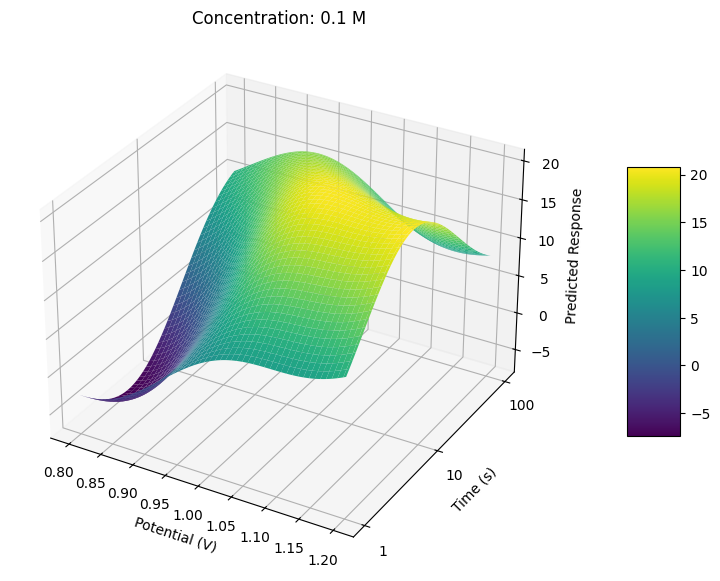

In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Generate the input grid for 0.1M concentration
concentration = 0.1  # 0.1M concentration
V, LogT = np.meshgrid(voltage_range, log_time_range)  # Assuming these are already defined
T = np.exp(LogT)  # Convert log-time back to original time scale

inputs_grid = np.stack((V.ravel(), T.ravel(), np.full(V.size, concentration)), axis=-1)

# Step 2: Scale the inputs (assuming `scale_inputs` is your scaling function)
inputs_scaled = scale_inputs(inputs_grid, voltage_bounds, time_bounds, concentration_bounds, 
                             voltage_target, time_target, concentration_target)

# Convert scaled inputs to tensor for model prediction
inputs_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)

# Step 3: Predict with the model
model.eval()  # Assuming 'model' is your trained model
with torch.no_grad():
    predictions = model(inputs_tensor).mean.numpy().reshape(V.shape)

# Step 4: Plot the surface with the best test point
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot for predictions
surf = ax.plot_surface(V, LogT, predictions, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.1)

ax.set_title('Concentration: 0.1 M')
ax.set_xlabel('Potential (V)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Predicted Response')  # Adjust label as needed

ax.set_yticks(np.log([1, 10, 100]))
ax.set_yticklabels(['1', '10', '100'])

# Assuming best_test_point_original matches the conditions for plotting
if np.isclose(best_test_point_original[2], 0.1, atol=0.01):
    log_time_best_point = np.log(best_test_point_original[1])
    ax.scatter(best_test_point_original[0], log_time_best_point, predictions.max(), color='red', s=50, depthshade=False)

plt.show()


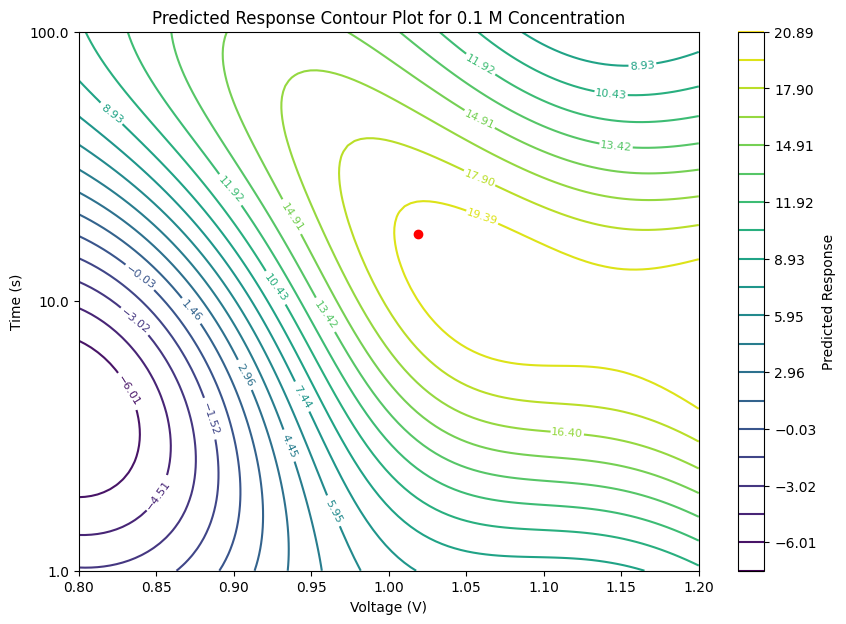

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Your predictions and voltage range (V) need to be defined here
# For illustration purposes, let's say predictions is a 2D array of your model's outputs
# and V and T have been defined as before

# Determine appropriate time ticks for log scale
time_ticks = np.log([1, 10, 100])  # Specify the time values you want to show as ticks
time_tick_labels = [f"{np.exp(tick):.1f}" for tick in time_ticks]  # Convert back to linear scale for labels

plt.figure(figsize=(10, 7))
# Create a contour plot with np.log(T) to represent log-scaled time on y-axis
CS = plt.contour(V, np.log(T), predictions, levels=np.linspace(predictions.min(), predictions.max(), num=20))
plt.clabel(CS, inline=True, fontsize=8)
plt.title('Predicted Response Contour Plot for 0.1 M Concentration')
plt.xlabel('Voltage (V)')
plt.ylabel('Time (s)')

# Set the custom ticks and labels to represent log-scaled time accurately
plt.yticks(time_ticks, time_tick_labels)

plt.colorbar(CS, label='Predicted Response')

# Include this line if you want to show the best test point
plt.scatter(best_test_point_original[0], np.log(best_test_point_original[1]), color='red', label='Best Test Point')

plt.show()


In [14]:
#Generate scatterplot performance gamut
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Get predictions for the training data
    observed_pred = likelihood(model(train_x))
    predictions = observed_pred.mean

predictions_np = predictions.numpy()
actual_responses_np = train_y.numpy()

import matplotlib.pyplot as plt
import numpy as np


# Plot of actual responses vs. bleachCP
plt.figure(figsize=(8, 6))
plt.scatter(bleachCP, actual_responses_np, alpha=0.5)
plt.xlabel('BleachCP')
plt.ylabel('Actual Response')
plt.title('Scatter Plot of Actual Response vs. BleachCP')
plt.grid(True)
plt.show()




NameError: name 'bleachCP' is not defined

<Figure size 800x600 with 0 Axes>